# Hands-on - Deep Learning para Reconhecimento de Padrões em Imagem
### Detecção de Derrame Pleural em Rx de Tórax

Densenvolvido por: Eduardo Pontes Reis e Felipe Nascimento

**REFERÊNCIAS:**

São utilizadas imagens selecionadas do dataset público NIH ChestXray14.

Parte do material didático foi baseado no tutorial 
[https://github.com/llSourcell/Convolutional_neural_network](https://github.com/llSourcell/Convolutional_neural_network)
e parte do código foi baseado no workshop realizado na JPR2018, entre outros códigos de caráter open source.



**OBJETIVO:**

Demonstrar os passos básicos para treinamento de rede neural convolucional para detectar derrame pleural.


**RECURSOS:**

O notebook do Kaggle é um computador em nuvem rodando um ambiente python contendo todas as configurações necessárias para machine learning.

Todo o processo é realizado em linguagem Python, utilizando bibliotecas como Keras/Tensorflow, Numpy, openCV, SKlearn, entre outras.

As bibliotecas específicas para cada tarefa são importadas ao longo do processo.

# Introdução à Rede Neural Convolucional (CNN)

As CNN são modelos inspirados na biologia do córtex visual dos mamíferos. Hubel e Wiesel (1960) propuseram explicação para a forma com que os mamíferos percebem visualmente o mundo ao seu redor utilizando arquitetura em camadas de neurônios no cérebro, e isso, por sua vez, inspirou os engenheiros a desenvolver mecanismos semelhantes de reconhecimento de padrões na visão computacional. A figura abaixo, inspirada por DiCarlo e Cox (2007), ilustra as transformações que ocorrem no fluxo visual ventral.

![alt text](https://github.com/EPreis/handsonfigs/blob/master/visualcortex2.jpg?raw=true)


Na hipótese dos autores citados, dentro do córtex visual, respostas funcionais complexas geradas por células "profundas" são construídas a partir de respostas simples de "élulas iniciais". Por exemplo, células simples responderão a linhas especificamente orientadas e bordas, enquanto células profundas também responderão a certas orientações, mas com grau progressivo de complexidade.

Basicamente uma célula profunda responde a soma de entradas de outras células iniciais. A arquitetura das redes neurais convolucionais foi inspirada nestas idéias.





# Iniciando o Processo
# Passo 1: Criando o dataset

**Dataset:**

    O NIH ChestXray14 contém cerca de 110.000 exames de raio x de tórax anotados em 14 diferentes categorias.

O conjunto de dados que é utilizado consiste de 350 imagens de RX de tórax normais e 350 RX com derrame, retiradas e selecionadas do dataset público NIH ChestXray14.


** Siga as instruções em texto e em azul dentro das células. **
#### Para executar cada célula, pressione SHIFT + ENTER

In [4]:
# As imagens do Dataset "RxTorax" que contém 350 imagens normais e 350 de derrame já estão vinculadas a este "Notebook"
# Para editar o dataset vinculado a este kernel vá em "Add Data" no menu à direita. 
# Agora que ja temos o dataset pronto, vamos criar uma lista dos arquivos utilizando o glob, que lê e lista os arquivos que existem dentro de uma pasta

from glob import glob

derrame_dir = '../input/effusion/*/*.png' #Define o caminho das pastas que contém as imagens
normal_dir = '../input/normal/*/*.png'

derrame_lista = glob(derrame_dir) #Lista os arquivos dentro de cada uma das pastas, usando o glob()
normal_lista = glob(normal_dir)


print('Número de casos com derrame: ', len(derrame_lista)) #Visualiza o tamanho da lista
print('Número de casos normais: ', len(normal_lista))
print ('\nEtapa Concluída. Vamos para a próxima!')

#Execute com SHIFT + ENTER

#O resultado esperado é:
#Número de casos com derrame:  350
#Número de casos normais:  350

Número de casos com derrame:  350
Número de casos normais:  350

Etapa Concluída. Vamos para a próxima!


# Visualizando seus dados

Pode-se também visualizar cada imagem do dataset. Por exemplo, para visualizar uma imagem com derrame: na linha "ID_arquivo" escolha um numero entre 0 e 349 e execute a célula, pode-se repetir o quanto necessário.

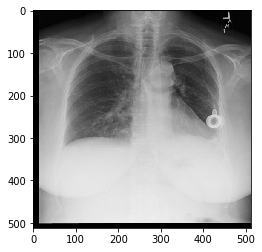

Classe:  Derrame

Etapa Concluída. Vamos para a próxima!


In [5]:
import cv2 #Para abrir o arquivo de imagem, utilizaremos o openCV, uma biblioteca aberta de visão computacional
from matplotlib import pyplot as plt #Biblioteca de plotagem de gráficos chamada a matplotlib

#Em 'Classe' digite 'N' para imagens da classe 'Normal', 
#ou substitua-o por 'D' para imagens com derrame
Classe = 'D'

#Escolha uma imagem entre 0 e 349:
ID_arquivo = 102

if Classe == 'N':
    classe = 'Normal'
    classe_lista = normal_lista
elif Classe == 'D':
    classe = 'Derrame'
    classe_lista = derrame_lista
    
imagem = cv2.imread(classe_lista[ID_arquivo])

plt.imshow(imagem)
plt.show()
    
print('Classe: ',classe)
print ('\nEtapa Concluída. Vamos para a próxima!')

#Execute com SHIFT + ENTER
#Pode modificar o ID_arquivo ou a Classe para vizualizar outras imagens. Pode repetir quantas vezes quiser

# **Como o computador enxerga uma imagem?**

Considere cada imagem como uma matriz em que o valor de cada pixel corresponde a um 
número que determina o tom de cinza da imagem.

![alt text](https://github.com/EPreis/handsonfigs/blob/master/8_digits.gif?raw=true)


Portanto, para enxergar os contornos de uma imagem o algoritmo tenta criar filtros que representem estes contornos em números, como no exemplo abaixo.

![alt text](https://github.com/EPreis/handsonfigs/blob/master/contornos.png?raw=true)




# Passo 2: Criando os Labels e transformando as imagens em matrizes (números)

É necessário informar explicitamente em qual categoria as imagens pertecem em uma lista denominada labels (derrame = 1, normal = 0). Isso será realizado ao mesmo tempo que as imagens são salvas em uma matriz, pois como as redes neurais tem entrada de tamanho fixo, é necessário redimensionar todas as imagens para tamanho único que deve ser exatamente o mesmo da primeira camada da rede neural convolucional (Input Layer) utilizada. Imagine que cada pixel será transformado em um número que será inserido em cada neurônio da primeira camada, para este caso será utilizado tamanho de 256 x 256 pixels.

In [6]:
import numpy as np #biblioteca NumPy para trabalharmos com matrizes
# Por que usamos matrizes? A entrada de informações nas redes neurais se dá nesse formato,
# o computador enxerga as imagens dessa forma e permite processamento computacional paralelo e maior velocidade de processamento.

dataset = [] # cria uma lista vazia para incluir as imagens do dataset
labels = [] # cria uma lista vazia para incluir a categoria a qual cada imagem pertence (0 ou 1)

for arquivo in derrame_lista: # para cada arquivo de imagem na lista derrame:
    img = cv2.imread(arquivo, cv2.IMREAD_GRAYSCALE) #abre o arquivo em escala de cinzas
    img = cv2.resize(img, (256,256)) #redimensiona a imagem para 256 x 256
    dataset.append(img) #adiciona essa imagem na lista do dataset que criamos acima
    labels.append(1) #informa que ela é um caso de derrrame (1)

#Agora faremos o mesmo para as imagens sem derrame
for arquivo in normal_lista:
    img = cv2.imread(arquivo, cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (256,256)) 
    dataset.append(img)
    labels.append(0) #mas agora informaremos que ela é um caso normal (0)

    

dataset = np.asarray(dataset, dtype=np.float32) #transforma a lista de variáveis numa matriz
labels = np.asarray(labels)

for i in range(len(dataset)):
  dataset[i] = (dataset[i] - np.average(dataset[i], axis= (0, 1))) / np.std(dataset[i], axis= (0, 1)) #faremos a normalização, dividindo a média pelo desvio padrão
  # normalização diminui a variabilizada do dataset, deixando os valores mais próximos um do outro
  
print('Dimensões da Matriz: ',dataset.shape)
print ('\nEtapa Concluída. Vamos para a próxima!')

#Vamos ver qual o tamanho dessa matriz 'dataset'
#Esperamos que a primeira dimensão dela seja de 700 (350 casos de derrame e 350 normais)
#A segunda e a terceira dimensões devem ser 256.

# a saída esperada é (700, 256, 256)

Dimensões da Matriz:  (700, 256, 256)

Etapa Concluída. Vamos para a próxima!


# Passo 3: Dividindo o dataset nos grupos Treinamento, Validação e Teste

![alt text](https://github.com/edureisMD/handsonfigs/blob/master/Captura.png?raw=true)

In [7]:
#Vamos separar nosso dataset em grupos de treinamento, validação e teste. Para isso, usaremos a biblioteca sklearn.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Vamos dividir o grupo de treino, validação e teste na proporção de cerca de 70%/15%/15%, 
#com valores aproximados para ficarmos com números redondos de 500/100/100

dataset_train, dataset_test, labels_train, labels_test = train_test_split(dataset[:,...,np.newaxis], labels[:,...,np.newaxis], test_size=0.142, random_state=80)
dataset_train, dataset_val, labels_train, labels_val = train_test_split(dataset_train, labels_train, test_size=0.1651, random_state=80)

print('(Número de imagens, Imagem_X, Imagem_Y, canais de cor) (Número de labels, 1)')
print(dataset_train.shape, labels_train.shape)
print(dataset_val.shape, labels_val.shape)
print(dataset_test.shape, labels_test.shape)

#Você deve ver a seguinte saída:
#(500, 256, 256, 1) (500,1)
#(100, 256, 256, 1) (100,1)
#(100, 256, 256, 1) (100,1)

print ('\nEtapa Concluída. Vamos para a próxima!')

(Número de imagens, Imagem_X, Imagem_Y, canais de cor) (Número de labels, 1)
(500, 256, 256, 1) (500, 1)
(100, 256, 256, 1) (100, 1)
(100, 256, 256, 1) (100, 1)

Etapa Concluída. Vamos para a próxima!


# Passo 4: Processo de Data Augmentation

O dataset utilizado é considerado pequeno, o que eleva a possibilidade de overfiting do modelo, ou seja, o modelo se torna especialista em apenas os RX de tórax apresentados, não conseguindo generalizar para variados RX de tórax do mundo real, com posições diferentes, coloração, entre outros.

Para aumentar artificialmente o número de exemplos, será utilizada técnica denominada Data Augmentation, que atua levemente na posição da imagem de forma aleatória, antes mesmo de apresentá-las para a rede neural. 

![alt text](https://github.com/EPreis/handsonfigs/blob/master/aug.002.jpeg?raw=true)

In [8]:
#Vamos importar as função do Keras que faz data augmentation:

from keras.preprocessing.image import ImageDataGenerator

#Aqui podemos definir diferentes variáveis que vão definir como as imagens  
#vão mudar em rotação, "corte" ou zoom.

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

print ('\nEtapa Concluída. Vamos para a próxima!')


Etapa Concluída. Vamos para a próxima!


# Passo 5: Criando a estrutura da rede neural convolucional

Convolução é uma operação matemática que consiste em multiplicar uma matriz (imagem) por um filtro (matrix de pesos).



---




Lembra-se de como o computador enxerga um contorno?
Através de uma matriz de números estratégicamente orientados:


![alt text](https://github.com/EPreis/handsonfigs/blob/master/Screen-Shot-2017-07-26-at-6.13.41-PM.png?raw=true)

---



Serão utilizados os filtros núméricos para enxergar os contornos ao longo de toda a imagem.

![alt text](https://media3.giphy.com/media/i4NjAwytgIRDW/giphy.gif?cid=ecf05e47xxytwe09f1mjua95h5exicu1gouki8wgenmql6sy&rid=giphy.gif)



Esta operação é repetida várias vezes para que a rede enxergue características cada vez mais complexas, gerando filtros decontornos assim como representado na famosa imagem da Lena.

![alt text](https://github.com/EPreis/handsonfigs/blob/master/contornos.png?raw=true)

In [9]:
#Nesta etapa vamos criar a arquitetura da nossa rede neural convolucional, 
#Utilizaremos a biblioteca Keras, própria para Deep Learning em Python
#Inicialmente vamos importar as funções do Keras que iremos utilizar:

from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Input, Concatenate, add
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense, LeakyReLU
from keras.utils.np_utils import to_categorical
import keras

#Agora criaremos a estrutura da rede neural convolucional

#A primeira camada define o tamanho da camada de entrada da rede
imgs = Input(shape=(256,256,1))

#Lembre que a nossa matriz com todas as 556 imagens de cada categoria tem o formato (556, 256, 256)
#Nesse caso a entrada (input) da rede é cada imagem individualmente
#Ou seja, uma imagem de tamanho 256 x 256 pixels e 1 canal de cor (escala de cinzas) (256, 256, 1)

#Agora vamos adicionar a primeira camada convolucional
x = Conv2D(8, 3, padding='same', activation='relu')(imgs)

#Em seguida, adicionamos uma camada MaxPool, que irá reduzir em 75% o tamanho da saída da camada convolucional.
#Fazemos isso para evitar que o número de parâmetros da rede aumente demais.
x = MaxPool2D()(x)

#Adicionaremos mais camadas convolucionais, seguidas de MaxPool
x = Conv2D(8, 3, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(12, 3, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(12, 3, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(20, 5, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(20, 5, padding='same', activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(50, 5, padding='same', activation='relu')(x)
x = GlobalAveragePooling2D()(x)

#Finalmente adicionaremos duas camadas densas, chamadas de 'Fully Connected Layers'.
#Essas camadas são redes neurais não convolucionais.
#Estas camadas recebem os parâmetros das primeiras e ajudam a realizar a classificação dos resultados
x = Dense(128, activation='relu')(x)

#Dropout é uma técnica para reduzir overfitting onde excluímos parte dos neurônios de uma camada.
x = Dropout(0.6)(x)

x = Dense(32, activation='relu')(x)

#Nossa camada de "output" tem o argumento "1" pois a saída da rede é a classificação derrame x não-derrame
#Ou seja, a saída da rede é apenas um número (0 ou 1)
outputs = Dense(1, activation='sigmoid')(x)

inputs = imgs

#Por fim, definiremos nossa rede com a entrada e a saída da rede
RadEinstein_CNN = Model(inputs=inputs, outputs=outputs)

#Agora, definiremos o método de otimização da rede: ADAM, com a taxa de aprendizado e de decaimento
#Cada um desses parâmetros é ajustável.
custom_adam = optimizers.Adam(lr=0.0005, decay=0.0002)

#Compila o modelo definindo o tipo de função 'loss', otimização e a métrica.
RadEinstein_CNN.compile(loss='binary_crossentropy', optimizer=custom_adam, metrics=['acc'])

print('Veja abaixo as camadas da sua rede neural' )
print('Note que cada camada contém uma quantidade diferente de parâmetros a serem treinados')
print('No final da lista, note que nossa rede contém um total de 54.627 parâmetros treináveis')
print ('\nRadEinstein_CNN Sumary')
RadEinstein_CNN.summary()
print ('\nEtapa Concluída. Vá para a próxima!')

Veja abaixo as camadas da sua rede neural
Note que cada camada contém uma quantidade diferente de parâmetros a serem treinados
No final da lista, note que nossa rede contém um total de 54.627 parâmetros treináveis

RadEinstein_CNN Sumary
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 8)         0         
___________________

# Passo 5: Treinando a rede neural

Durante o treinamento da rede, os pesos sinápticos de todas as camadas são atualizados. Após a conclusão do treinamento, cada filtro representará uma característica de imagem a ser procurada nas imagens do nosso dataset. 

Na linha "hist" são definimos alguns hyperparameters, como por exemplo o número de épocas em 60, que significa por quantas repetições (épocas) é realizado o treinamento. Para treinar ainda mais a sua rede, altere o número para até 100 épocas, e analise os resultados.

Com estes parâmetros, o modelo levará entre 5 e 10 minutos para ser treinado.

Treinando a Rede RadEinstein_CNN:
Epoch 1/100
500/500 [==============================] - 132s 263ms/step - loss: 0.6402 - acc: 0.6113 - val_loss: 0.4921 - val_acc: 0.7900

Epoch 00001: val_loss improved from inf to 0.49206, saving model to Melhor_modelo.hdf5
Epoch 2/100
500/500 [==============================] - 129s 258ms/step - loss: 0.5153 - acc: 0.7500 - val_loss: 0.4133 - val_acc: 0.7800

Epoch 00002: val_loss improved from 0.49206 to 0.41325, saving model to Melhor_modelo.hdf5
Epoch 3/100
500/500 [==============================] - 130s 260ms/step - loss: 0.4110 - acc: 0.8251 - val_loss: 0.2563 - val_acc: 0.8900

Epoch 00003: val_loss improved from 0.41325 to 0.25633, saving model to Melhor_modelo.hdf5
Epoch 4/100
500/500 [==============================] - 131s 261ms/step - loss: 0.3333 - acc: 0.8645 - val_loss: 0.2644 - val_acc: 0.9100

Epoch 00004: val_loss did not improve from 0.25633
Epoch 5/100
500/500 [==============================] - 131s 262ms/step - loss: 0.2905 - acc: 0

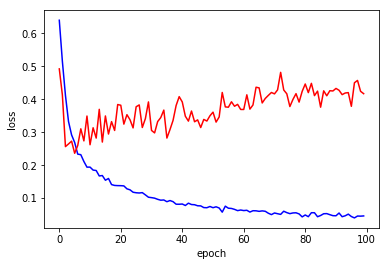

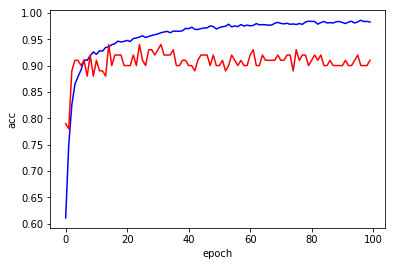


Agora vamos avaliar o modelo no dataset de teste. Vamos para a próximo comando.


In [10]:
import time #Função time para medirmos o tempo de treinamento

checkpointer = ModelCheckpoint(filepath='Melhor_modelo.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True) #Salvar o melhor modelo que for encontrado durante o treino

print('Treinando a Rede RadEinstein_CNN:')

Valida = (dataset_val, labels_val)

# Finalmente vamos treinar a nossa rede
# Se quiser treinar sua rede um pouco mais, altere o número de epochs, 
# e vamos ver os diferentes resultados.

start_time = time.time()
hist = RadEinstein_CNN.fit_generator(datagen.flow(dataset_train, labels_train, batch_size=16), 
                                     steps_per_epoch=len(dataset_train), 
                                     epochs=100, 
                                     validation_data= (dataset_val, labels_val), 
                                     callbacks=[checkpointer])

#Definimos o treinamento com o dataset de treino, realizando validação no dataset de validação.
#O treinamento não usa o dataset de teste, ficará guardado para avaliarmos nossa rede depois.

tempo = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
print('')
print('Treino finalizado em %s' % tempo)

#Por fim, plotamos os resultados de evolução da medida de erro (loss) e acurácia ao longo dos epochs
plt.plot(hist.history['loss'], 'b-', label='train loss')
plt.plot(hist.history['val_loss'], 'r-', label='val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(hist.history['acc'], 'b-', label='train accuracy')
plt.plot(hist.history['val_acc'], 'r-', label='val accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

print ('\nAgora vamos avaliar o modelo no dataset de teste. Vamos para a próximo comando.')

#Execute esse código com SHIFT + ENTER


A menor diferença entre o que o algoritmo prediz e a resposta correta, esta diferença é chamada de perda (loss), quanto menor a perda (loss), mais o seu algoritmo esta acertando, consequentemente maior é a acurácia (acc).

![alt text](https://i1.wp.com/francescolelli.info/wp-content/uploads/2019/05/NeuralNetworks-input-layer-hidden-layer-output-layer.png?resize=448%2C293&ssl=1)
Fonte: https://francescolelli.info/tutorial/neural-networks-a-collection-of-youtube-videos-for-learning-the-basics/


O gráfico abaixo ilustra o processo de otimização para o treinamento da rede neural, buscando o ponto de menor perda (loss) (em cor azul escuro). O processo de otimização pode percorrer vários caminhos diferentes de forma heurística ou determinística, por isso é necessário repetir o processo várias vezes, até o algoritmo de otimização atingir um mínimo local ou o mínimo global. O algoritmo de otimização é de extrema importância no processo de treinamento das redes neurais, pois em cada caso específico pode-se utilizar tipos diferentes de otimizador buscando assim atingir melhorar a acurácia no modelo.

![alt text](https://regenerativetoday.com/wp-content/uploads/2019/06/GradientDescentWithMutlipleLocalMinimum.jpg)
Fonte: https://regenerativetoday.com/machine-learning-gradient-descent-concept/



# Passo 6: Avaliação do algoritmo no dataset de Teste

Nesta estapa, será apresentado todo o dataset de teste para o modelo desenvolvido, de forma a calcular a acurácia da rede neural em um grupo de imagens que o modelo desconhece.

In [11]:
from keras.models import load_model #Vamos importar a função do keras que abre modelos salvos previamente

melhor_modelo = load_model('Melhor_modelo.hdf5') #Abrimos o melhor modelo que salvamos no treinamento

print ('\nPesos da rede neural atualizados para os da melhor época.')
print ('\nEtapa Concluída. Vamos para a próxima!')
#Execute esse código com SHIFT + ENTER


Pesos da rede neural atualizados para os da melhor época.

Etapa Concluída. Vamos para a próxima!


In [12]:
#Usamos a função evaluate para avaliar a acurácia do nosso modelo no grupo de teste
print('Acurácia no grupo de teste: ', melhor_modelo.evaluate(dataset_test, labels_test, verbose=0)[1])

print ('\033[1m' + 'Etapa Concluída. Vamos para a próxima!')
#Execute esse código com SHIFT + ENTER

Acurácia no grupo de teste:  0.9900000095367432
Etapa Concluída. Vamos para a próxima!


## # Passo 7: Verificação da predição caso a caso

In [13]:
# Instale a biblioteca Keras-vis para visualizarmos como a rede neural enxerga a imagem.
# Se tiver problemas com a instalação ative o campo "internet" na barra lateral de configurações -->
!pip install -q keras-vis
print ('\033[1m' + 'Instalação concluída. Vamos para a próxima etapa!')


Instalação concluída. Vamos para a próxima etapa!


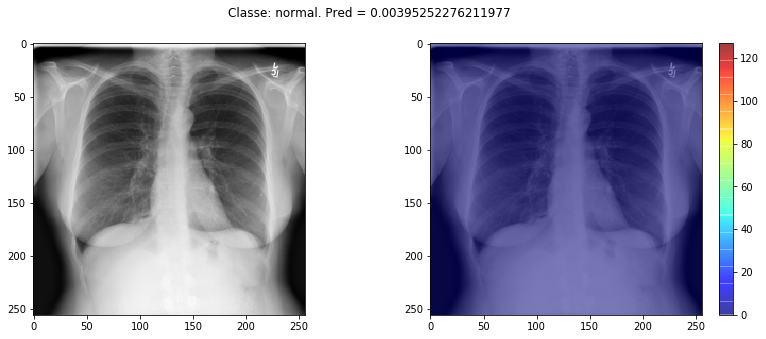

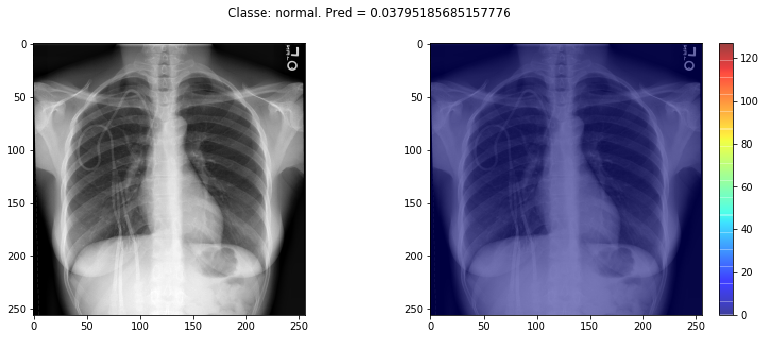

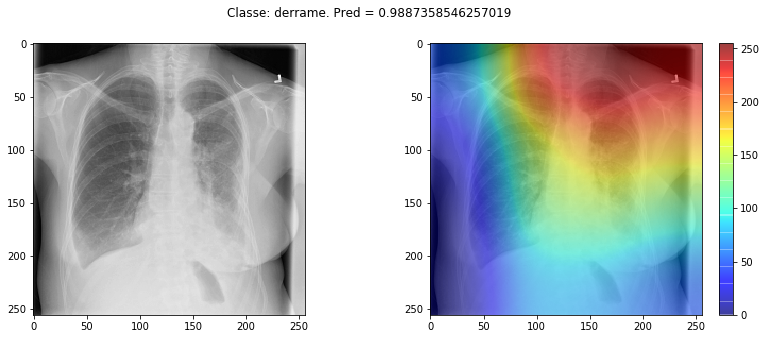

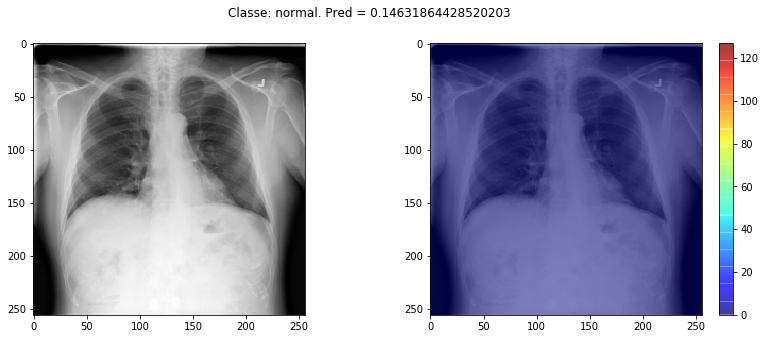

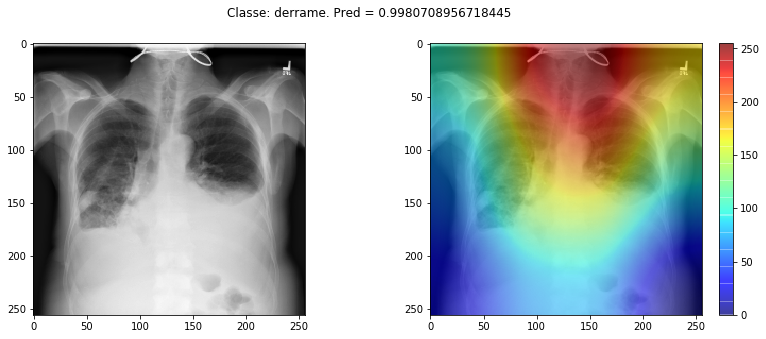

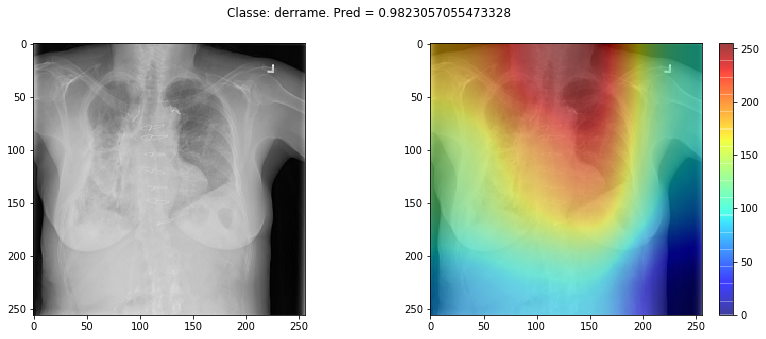

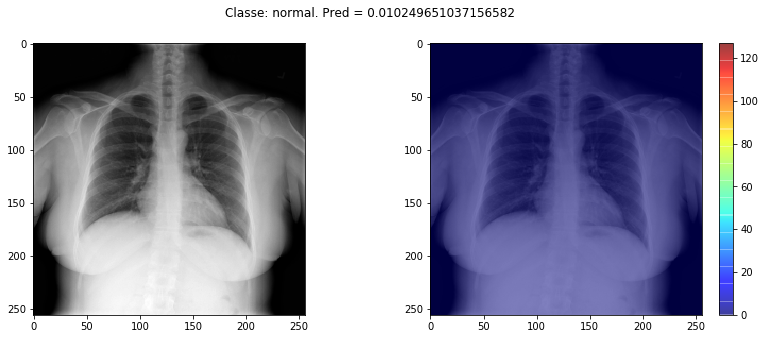

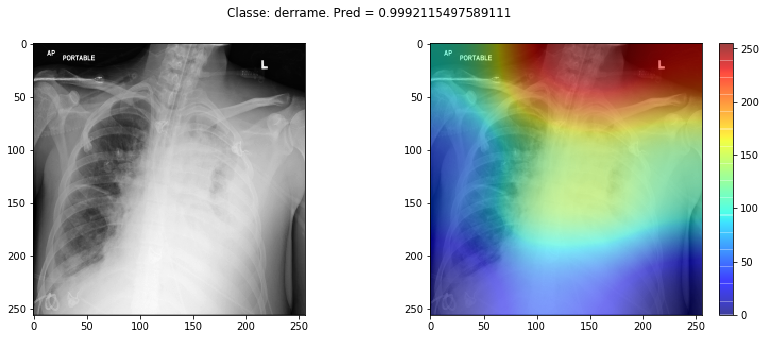

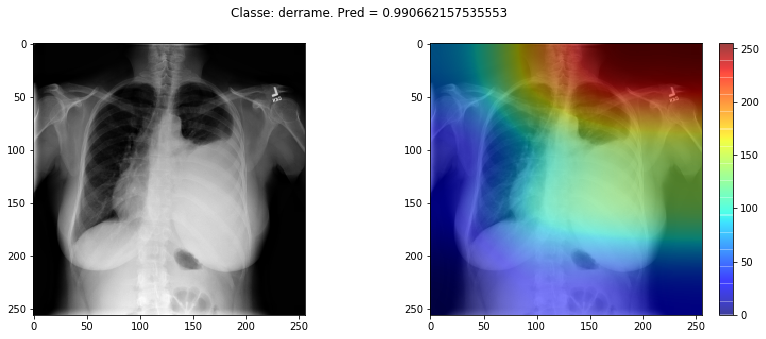

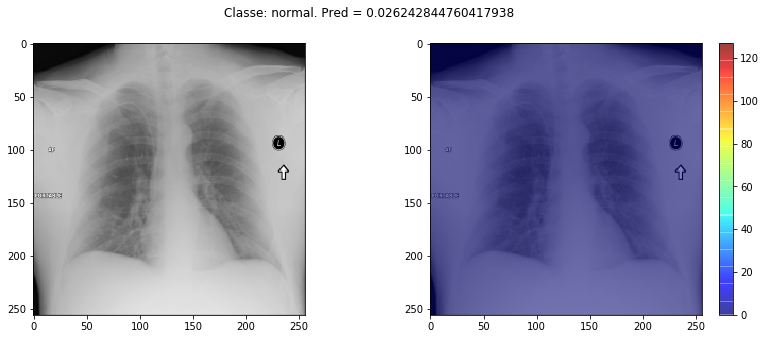

In [14]:
# Agora vamos visualizar as predições para algumas imagens
# e visualizar o mapa de ativação no nosso dataset de teste.

# Fonte: https://fairyonice.github.io/Grad-CAM-with-keras-vis.html

from vis.visualization import visualize_cam
import matplotlib.cm as cm
import random 

def plot_map(grads, classe, predicao):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(np.squeeze(img), cmap='gray')
    axes[1].imshow(np.squeeze(img), cmap='gray')
    i = axes[1].imshow(grads,cmap="jet",alpha=0.5)
    fig.colorbar(i)
    plt.suptitle("Classe: {}. Pred = {}".format(classe, predicao))
    
for n in range(10):
    i = random.randrange(0,100)
    ID_imagem = i
    
    img = dataset_test[ID_imagem]
    layer_idx = 18
    penultimate_layer_idx = 13
    class_idx  = 0
    seed_input = img
    grad_top1  = visualize_cam(melhor_modelo, layer_idx, class_idx, seed_input, 
                               penultimate_layer_idx = penultimate_layer_idx,#None,
                               backprop_modifier     = None,
                               grad_modifier         = None)
    
    #Vamos mostrar a qual classe ela pertence
    _classe = 'normal' if labels_test[ID_imagem]==0 else 'derrame'

    _predicao = melhor_modelo.predict(dataset_test[ID_imagem][np.newaxis,:,...], verbose=0)

    plot_map(grad_top1, _classe, _predicao[0][0])

## # Passo 8: Execução da última célula para concluir o treinamento:

In [15]:
from IPython.display import HTML, display
print ('\n' + '\033[1m' + 'Ótimo trabalho! Parabéns, você treinou sua primeira rede neural!\n')
display(HTML('<img src="https://media0.giphy.com/media/S6TEoUBJuGfQCoGl8l/giphy.gif?cid=ecf05e47oxgcxjd98g6ghdaalezi4jhrkxmig00jf8vhg2np&rid=giphy.gif">'))



Ótimo trabalho! Parabéns, você treinou sua primeira rede neural!

